In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
#convert to tensor and binarize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float())
])

train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 58.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.78MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.88MB/s]


In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc_mu = nn.Linear(400, 2)
        self.fc_logvar = nn.Linear(400, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


In [ ]:
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std


In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 400)
        self.fc2 = nn.Linear(400, 784)

    def forward(self, z):
        z = torch.relu(self.fc1(z))
        return torch.sigmoid(self.fc2(z))


In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar


In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(
        recon_x, x, reduction='sum'
    )

    KLD = -0.5 * torch.sum(
        1 + logvar - mu.pow(2) - logvar.exp()
    )

    return BCE + KLD


In [ ]:
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, _ in train_loader:
        images = images.view(-1, 784)

        optimizer.zero_grad()
        recon, mu, logvar = model(images)
        loss = vae_loss(recon, images, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader.dataset):.4f}")


Epoch 1, Loss: 188.1774
Epoch 2, Loss: 164.3809
Epoch 3, Loss: 159.7567
Epoch 4, Loss: 157.0701
Epoch 5, Loss: 155.2762
Epoch 6, Loss: 153.9455
Epoch 7, Loss: 152.8396
Epoch 8, Loss: 151.8587
Epoch 9, Loss: 151.0359
Epoch 10, Loss: 150.3493


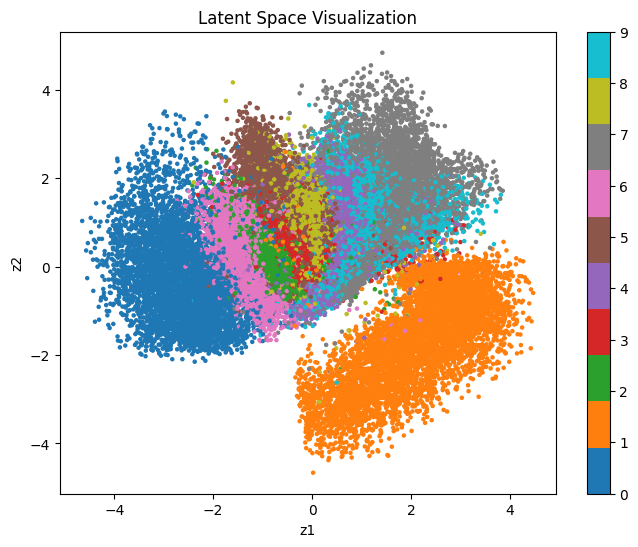

In [ ]:
model.eval()
latents = []
labels = []

with torch.no_grad():
    for images, lbls in train_loader:
        images = images.view(-1, 784)
        mu, _ = model.encoder(images)
        latents.append(mu)
        labels.append(lbls)

latents = torch.cat(latents).numpy()
labels = torch.cat(labels).numpy()

plt.figure(figsize=(8,6))
plt.scatter(latents[:,0], latents[:,1], c=labels, cmap='tab10', s=5)
plt.colorbar()
plt.xlabel("z1")
plt.ylabel("z2")
plt.title("Latent Space Visualization")
plt.show()



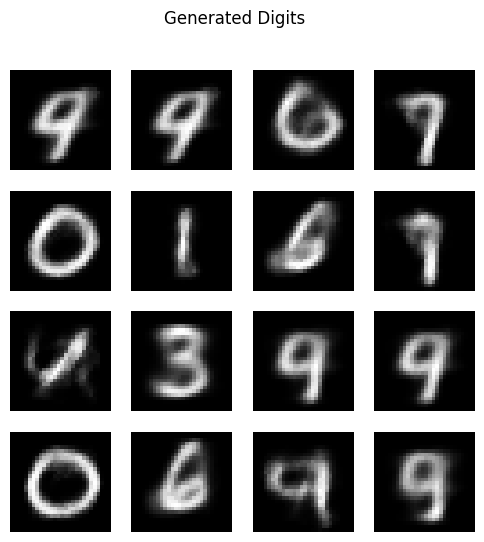

In [ ]:
with torch.no_grad():
    z = torch.randn(16, 2)
    samples = model.decoder(z)

samples = samples.view(-1, 28, 28)

plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(samples[i], cmap='gray')
    plt.axis('off')
plt.suptitle("Generated Digits")
plt.show()
